In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns
import numpy as np

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 100)

## DataFrame of Image Paths, Labels, and Bounding Boxes

Images of U.S. passenger vehicles by make, model, year, and category (e.g. car, pickup, van) were obtained by scraping Google Images using the script `./create_training_images/scrape_vehicle_make_models.py`. This scraped the first 100 images, saving these locally. The list of vehicle makes and models was obtained from the [back4app.com](https://www.back4app.com/database/back4app/car-make-model-dataset) database, including all vehicles present in U.S. market starting in the year 2000. An analysis of this database can be found under `./create_training_images/back4app_database_analysis.ipynb`. In this notebook, we compare scraped image results to the back4app.com database.

The images referenced in the Pandas DataFrame `df` below have all been unduplicated by URL. Approximately 11% of scraped images were from a duplicate URL (i.e. the same image was present more than once within the same scraping query or across different queries) or were missing URL information. Images with a duplicate or missing URL were deleted from this DataFrame.

In [2]:
df = pd.read_csv('../data/Bboxes.csv')

### Vehicle makes among scraped images

In [3]:
df.Make.unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Fiat', 'Ford', 'GMC', 'HUMMER', 'Honda',
       'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover',
       'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mercury',
       'Mitsubishi', 'Nissan', 'Pontiac', 'Porsche', 'RAM', 'Saab',
       'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota',
       'Volkswagen', 'Volvo', 'smart'], dtype=object)

In [4]:
df.Make.nunique()

40

In [5]:
df.head()

,Make,Model,Category,Source Path,URL,Bboxes,Dims
0,Acura,CL,Car,Acura/CL/2001/f04ed53e11.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[3.0, 56.0, 252.0, 138.0, 0.88232421875]","[194.0, 259.0, 3.0]"
1,Acura,CL,Car,Acura/CL/2001/6084dddd71.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[3.0, 54.0, 248.0, 157.0, 0.859375]","[194.0, 259.0, 3.0]"
2,Acura,CL,Car,Acura/CL/2001/723a443ab2.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[16.0, 48.0, 239.0, 152.0, 0.931640625]","[194.0, 259.0, 3.0]"
3,Acura,CL,Car,Acura/CL/2001/cb6d1e23cb.jpg,https://www.carspecs.us/photos/7d756cd1c893894...,"[29.0, 152.0, 1787.0, 920.0, 0.89453125]","[994.0, 1836.0, 3.0]"
4,Acura,CL,Car,Acura/CL/2001/ede0361fca.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[37.0, 60.0, 254.0, 139.0, 0.9306640625]","[168.0, 300.0, 3.0]"


In [6]:
df.shape

(690014, 7)

### Make Model Database

In [7]:
db = pd.read_csv('../data/make_model_database_mod.csv')

### Verify Completeness of Vehicle Make

In [8]:
# Verify no makes missing
assert(len([i for i in db.Make.unique() if i not in df.Make.unique()]) == 0)

### Verify Completeness of Make-Model

In [9]:
merged = db[['Make', 'Model']].drop_duplicates().merge(df[['Make', 'Model']].drop_duplicates(), indicator=True)

In [10]:
assert((merged._merge == 'both').all())

In [11]:
print(f"Number of unique make-models: {len(merged)}")

Number of unique make-models: 574


# Image Counts per Make-Model

The following examines the number of scraped images per vehicle make-model combination, regardless of whether that particular image has an associated YOLOv5 bounding box.

In [12]:
make_model = pd.DataFrame((df['Make'] + ' ' + df['Model']), columns=['Make_Model'])
make_model['Count'] = 1
make_model = make_model.groupby('Make_Model')['Count'].count().reset_index()

In [13]:
make_model['Count'].describe()

count      574.000000
mean      1202.114983
std       1384.318533
min         90.000000
25%        370.750000
50%        752.000000
75%       1494.750000
max      12122.000000
Name: Count, dtype: float64

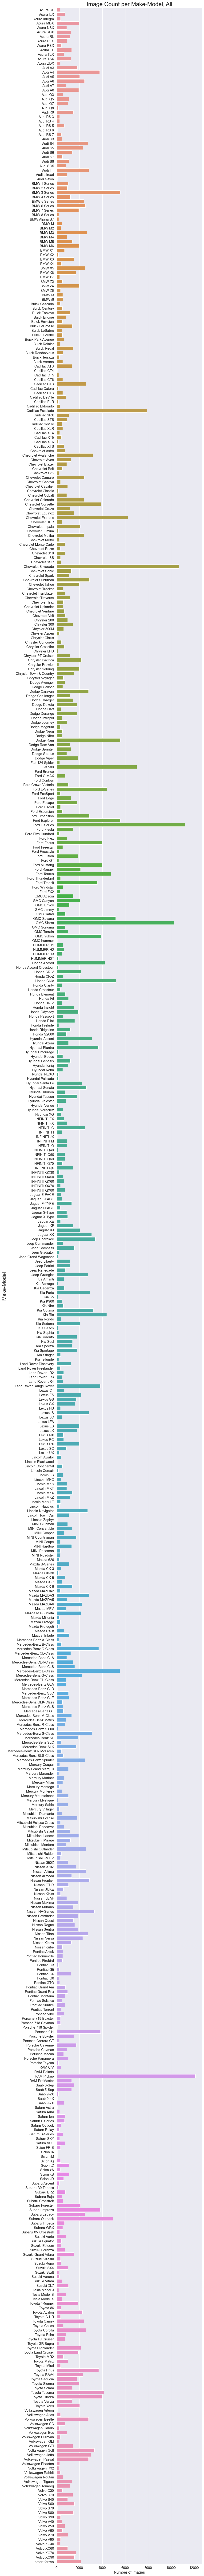

In [14]:
figure(figsize=(10, 180), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model, x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, All", fontsize=22)
plt.show()

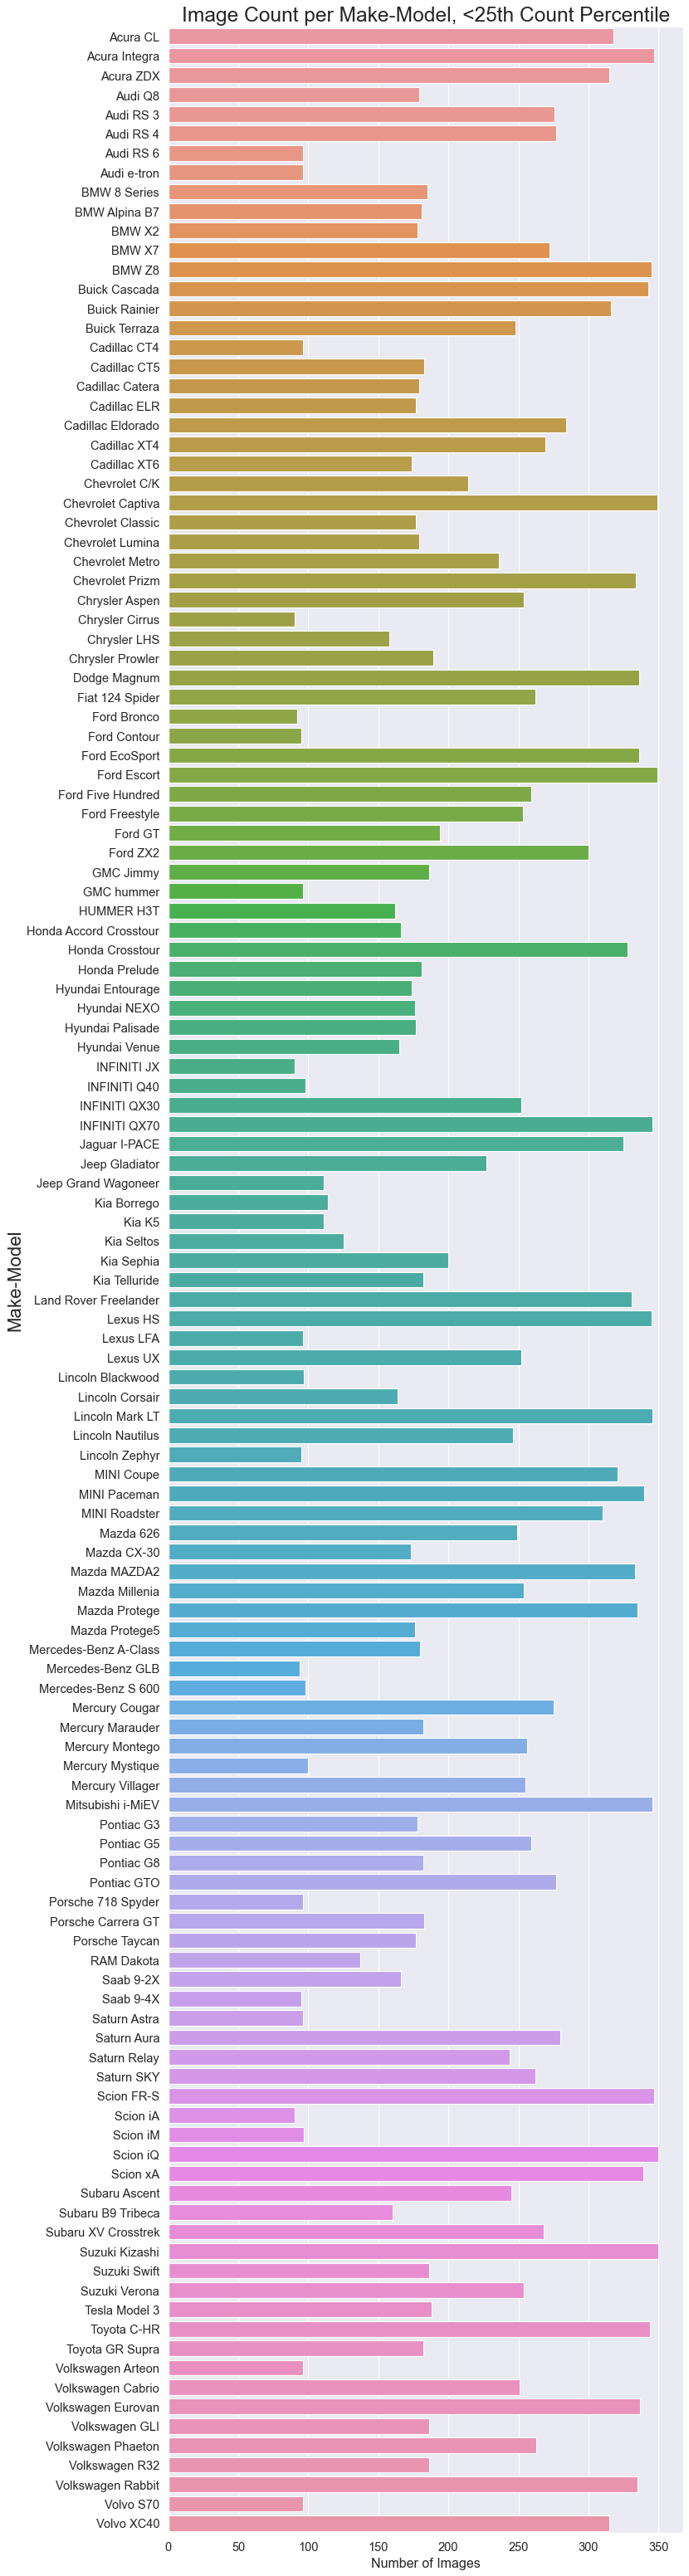

In [15]:
figure(figsize=(10, 50), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model.loc[make_model['Count'] < 351], x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, <25th Count Percentile", fontsize=22)
plt.show()

# Image Counts per Make-Model with YOLOv5 (XL) Bounding Boxes

We use the YOLOv5 algorithm, specifically the extra large (XL) model variant, to tag relevant objects in images. We keep objects that the algorithm labels as either a car, truck, or bus and whose bounding box confidence was >= 0.75. If multiple such objects are identified in a particular image, we keep the one with the largest bounding box area. Below we analyze the distribution of bounding box area and confidence.

In [16]:
df['Bboxes'] = df['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
subset = df.loc[df.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes

In [17]:
df.shape

(690014, 7)

In [18]:
subset.shape

(656294, 7)

In [19]:
print("Number of images without a bounding box: {:,}".format(len(df) - len(subset)))
print("Share of images without a bounding box: {:.2%}".format(1- (len(subset)/len(df))))

Number of images without a bounding box: 33,720
Share of images without a bounding box: 4.89%


### Distribution of images per class, conditional on having a YOLOv5 bounding box

In [20]:
make_model_reduced = pd.DataFrame((subset['Make'] + ' ' + subset['Model']), columns=['Make_Model'])
make_model_reduced['Count'] = 1
make_model_reduced = make_model_reduced.groupby('Make_Model')['Count'].count().reset_index()
make_model_reduced['Count'].describe()

count      574.000000
mean      1143.369338
std       1339.170156
min         74.000000
25%        354.000000
50%        709.000000
75%       1408.250000
max      11920.000000
Name: Count, dtype: float64

#### Distribution of confidence, conditional on having a YOLOv5 bounding box

In [21]:
subset['conf'] = subset['Bboxes'].apply(lambda x: x[-1])

In [22]:
subset['conf'].describe()

count    656294.000000
mean          0.825433
std           0.129141
min           0.250244
25%           0.788574
50%           0.871582
75%           0.912109
max           0.962891
Name: conf, dtype: float64

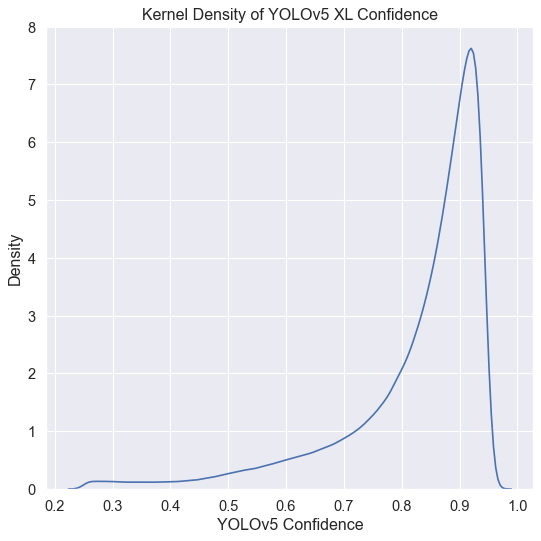

In [23]:
figure(figsize=(7, 7), dpi=80)
sns.kdeplot(subset['conf'])
plt.title('Kernel Density of YOLOv5 XL Confidence')
plt.xlabel('YOLOv5 Confidence')
plt.tight_layout()
plt.savefig('kdeplot_yolo_confidence.png', dpi=80)
plt.show()

### Distribution of YOLOv5 bounding box area

In [24]:
subset['area'] = subset['Bboxes'].apply(lambda x: (x[3] - x[1]) * (x[2] - x[0])).astype(int) # Format: xyxy
subset = subset.sort_values(by='area').reset_index(drop=True)

In [25]:
subset['area'].describe()

count    6.562940e+05
mean     1.740781e+05
std      3.862843e+05
min      2.400000e+01
25%      2.459800e+04
50%      3.456000e+04
75%      1.443420e+05
max      1.334594e+07
Name: area, dtype: float64

In [26]:
ecdf = subset['area'].cumsum() / subset['area'].sum()
ecdf.index = np.sqrt(subset['area'])

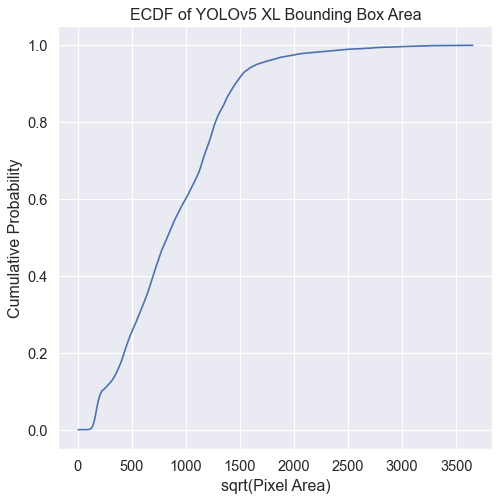

In [27]:
figure(figsize=(7, 7), dpi=80)
plt.plot(ecdf)
plt.xlabel('sqrt(Pixel Area)')
plt.ylabel("Cumulative Probability")
plt.title("ECDF of YOLOv5 XL Bounding Box Area")
plt.savefig('ecdf_bounding_box_area.png', dpi=80)
plt.show()

In [28]:
thresh = subset['area'].quantile(0.01)
print(round(thresh))
print(f"Equivalent to {round(np.sqrt(thresh))} x {round(np.sqrt(thresh))} image")

8911
Equivalent to 94 x 94 image


### Restrict to images whose bounding box area is > 1st percentile

In [29]:
subset = subset.loc[subset['area'] > thresh]

In [30]:
subset.shape

(649731, 9)

### Distribution of images per class, conditional on adequately-sized bounding box

In [31]:
make_model_reduced = pd.DataFrame((subset['Make'] + ' ' + subset['Model']), columns=['Make_Model'])
make_model_reduced['Count'] = 1
make_model_reduced = make_model_reduced.groupby('Make_Model')['Count'].count().reset_index()
make_model_reduced['Count'].describe()

count      574.000000
mean      1131.935540
std       1327.933656
min         72.000000
25%        346.000000
50%        705.500000
75%       1384.750000
max      11788.000000
Name: Count, dtype: float64

In [32]:
img_count = make_model_reduced['Count'].sort_values().reset_index(drop=True)
ecdf_img_count = img_count.cumsum() / img_count.sum()
ecdf_img_count.index = img_count

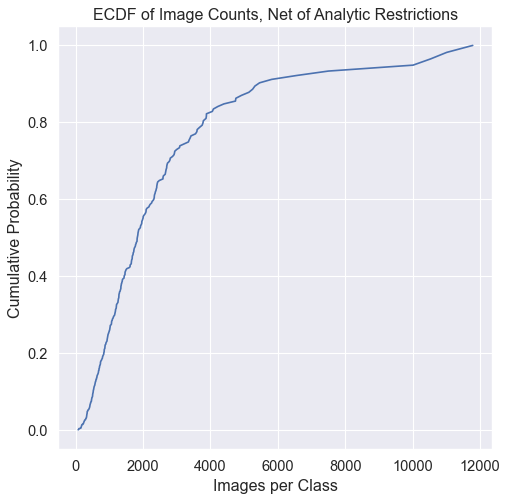

In [33]:
figure(figsize=(7, 7), dpi=80)
plt.plot(ecdf_img_count)
plt.xlabel('Images per Class')
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Image Counts, Net of Analytic Restrictions")
plt.savefig('ecdf_img_count.png', dpi=80)
plt.show()

In [ ]:
figure(figsize=(8, 160), dpi=80)
sns.set(font_scale=1.1)
sns.barplot(data=make_model_reduced, x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Final Image Count per Class", fontsize=22)
plt.tight_layout()
plt.savefig('final_img_count_class.png', dpi=80)
plt.show()

In [ ]:
figure(figsize=(10, 50), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model_reduced.loc[make_model_reduced['Count'] < 287], x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Final Image Count per Class, <25th Percentile", fontsize=20)
plt.show()